In [1]:
import numpy as np
import pandas as pd
import dill as pickle

%load_ext autoreload
%autoreload 1
%aimport CodingFeatures
%aimport CodingTransformers

In [2]:
from CodingFeatures import reverse_complement

with open('../data/BW25113genome.txt','r') as f:
    seq_raw_f = f.readlines()
seq_raw_f = [x.strip().upper() for x in seq_raw_f]
seq_raw_f = ''.join(seq_raw_f)
seq_raw_rc = reverse_complement(seq_raw_f)

## Import and initialize genome data and reference tables

In [3]:
from CodingFeatures import codon_lookup

codon_table, c_lookup = codon_lookup()
AA_list = codon_table['aa'].unique()[1:]

In [138]:
from CodingFeatures import DNAAttributeConstruction, fragment_stop_delimited, fragment_windowed

genomeF_object = DNAAttributeConstruction(seq_raw_f).decode_dna(c_lookup)
genomeR_object = DNAAttributeConstruction(seq_raw_rc).decode_dna(c_lookup)

## Feature extraction and model predictions

In [5]:
with open('../models/FU_v01a.pkl','rb') as f:
    FU = pickle.load(f)

with open('../models/RFCmodel_v01a.pkl','rb') as f:
    model = pickle.load(f)

In [6]:
genomeF_features = FU.transform(genomeF_object)
genomeR_features = FU.transform(genomeR_object)

In [7]:
with open('../models/features_genome_v01a.pkl','wb') as f:
    pickle.dump((genomeF_features,genomeR_features),f)

In [ ]:
with open('../models/features_genome_v01a.pkl','rb') as f:
    genomeF_features,genomeR_features = pickle.load(f)

In [140]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [168]:
def get_results(obj, features, model, reverse=False, max_len=len(seq_raw_rc)):
    '''Grab object info and model predictions.  Reverses index values for RC strand.'''
    results = pd.DataFrame(obj.frag_index, columns=['idg', 'idn'])
    results['seq_frag'] = obj.fragments
    results['end_frag'] = results.idn + results.seq_frag.map(len)
    results['predict'] = model.predict(features)
    results['strand'] = 1
    if reverse:
        results['idg'] = max_len - results['idg']
        results['idn'] = max_len - results['idn']        
        results['end_frag'] = max_len - results['end_frag']
        results['strand'] = -1
    return results

In [181]:
results = get_results(genomeF_object, genomeF_features, model)
results = results.append(get_results(genomeR_object, genomeR_features, model, True))

In [182]:
from CodingFeatures import seq_merge

summary = pd.DataFrame()
summary['start'] = results.groupby(['idg','strand']).apply(lambda x: x.idn.min()+1 if x.strand.mean() > 0 else x.idn.max()+1)
summary['stop'] = results.groupby(['idg','strand']).apply(lambda x: x.end_frag.max() if x.strand.mean() > 0 else x.end_frag.min()+1)
summary['avg_score'] = results.groupby(['idg','strand']).predict.mean()
summary['n_windows'] = results.groupby(['idg','strand']).predict.count()
summary['seq'] = results.groupby(['idg','strand']).seq_frag.apply(seq_merge)
summary.reset_index(inplace=True)

stat_pos, stat_tot = summary[summary.avg_score >= .5].avg_score.count(), summary.shape[0]

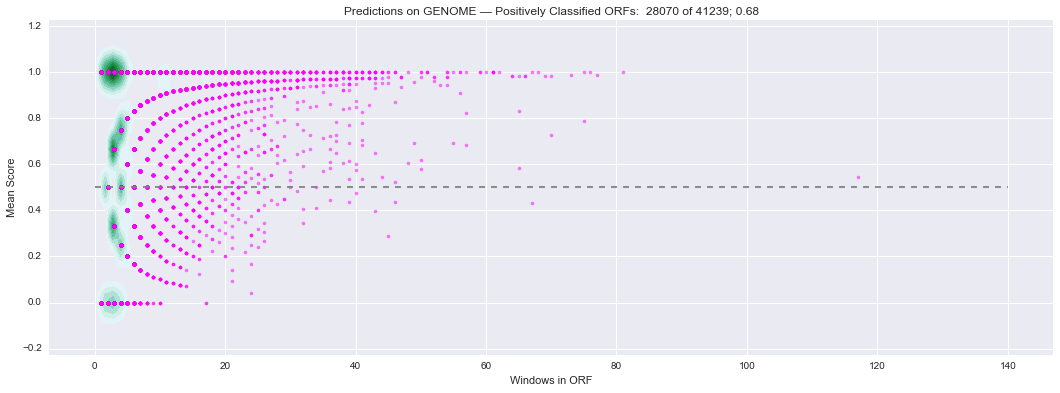

In [158]:
fig,ax = plt.subplots(figsize=(18,6))
ax.set_title('Predictions on GENOME — Positively Classified ORFs:  {0} of {1}; {2:.{3}f}'.format(stat_pos,stat_tot,stat_pos/stat_tot,2))
ax.set_xlabel('Windows in ORF')
ax.set_ylabel('Mean Score')
ax.hlines(.5,0,140,linestyles='dashed', color='grey')
sns.kdeplot(summary[['n_windows','avg_score']], shade=True, shade_lowest=False, ax=ax)
ax.scatter(summary.n_windows, summary.avg_score, color='magenta', alpha=.5, s=10)

In [159]:
print(results.columns)
print(summary.columns)

Index(['idg', 'idn', 'seq_frag', 'end_frag', 'predict', 'strand'], dtype='object')
Index(['idg', 'strand', 'start', 'stop', 'avg_score', 'n_windows', 'seq'], dtype='object')


In [171]:
# get annotated protein sequences
annotated = pd.read_csv('../data/BW25113proteome_dnaseq.csv') # get full sheet
annotated = annotated.drop_duplicates('seq').dropna() # drop duplicated proteins and missing DNA_seq
annotated['DNA_seq'] = annotated['DNA_seq'].apply(lambda x: x[3:]) # trim start codons from DNA_seq
annotated['start'] = annotated['start'] + 3 # increment sequence location index

In [205]:
joined = pd.merge(annotated, summary, 'outer', 'stop', suffixes=('_an', '_pred'))
joined.sort_values('stop', inplace=True)

In [206]:
joined.to_csv('../output/genome_predictions_v01a.csv')